In [2]:
import time
import os
import gc
import glob

import numpy as np
import pandas as pd
import xarray as xr

import dask
import dask.array as da
from dask import delayed, compute

import cftime
import pop_tools

# compute size of all files

### how many files are there?

In [3]:
filename = f"change_point_indices_1.0_20_20.csv"
path = os.path.join(os.environ['HOME'], 'phase1_CONDA/publishable_code')
file = os.path.join(path, filename)
df = pd.read_csv(file)

In [4]:
df.shape

(822, 3)

822 * 8GB = 6,6 TB

-> need to reduce size of file when loading

### what precision type do the variables have?

float64


-> I will for now reduce to float16

With float16, the rounding error can be up to approximately ±0.005, which can significantly impact the precision required for 0.01 degree accuracy.

-> NetCDF does not support float16 data type

convert to 32

# work efficiently with dask

### Explicit Cluster Setup

Using LocalCluster and Client allows you to configure and monitor the cluster, providing more control over the execution environment.

### Check Server Resources:
   - Check CPU and memory.

```sh
lscpu
free -h
```

### Server specifications

- **72 CPU cores** (36 physical cores with Hyper-Threading enabled, resulting in 72 logical cores).
- **1.5TB of RAM**.

### Approach:

1. **Initial Configuration**: Start with 36 workers, 2 threads per worker, and 32GB memory per worker.
2. **Monitor and Adjust**: Use the Dask dashboard to monitor resource usage and adjust the number of workers, threads, and memory limits based on performance.

```python
import dask
from dask.distributed import Client, LocalCluster

# Set up Dask cluster
cluster = LocalCluster(n_workers=36, threads_per_worker=2, memory_limit='32GB')
client = Client(cluster)
print(client)  # Provides a dashboard URL for monitoring
```

# approach of computation save immediately

- load file - check
- reduce size - check
- extract event - check
- extract composite - check
- save composite (parallel)
- close dataset
- extract members parallel
- after one third of the data is computed: take average depending on above or below
- delete remaining files
- close dataset
- compute average over all three average
- delete all averages

In [8]:
# Load data and group csv file by member
filename = f"change_point_indices_1.0_40_20.csv"
path = os.path.join(os.environ['HOME'], 'phase1_CONDA/publishable_code')
file = os.path.join(path, filename)
df = pd.read_csv(file)
grouped = df.groupby('Member')

# Extract the variables from the filename
filename = os.path.basename(file)
parts = filename.replace('change_point_indices_', '').replace('.csv', '').split('_')
threshold_multiple = float(parts[0])
P1_len = int(parts[1])
P2_len = int(parts[2])

# set up mask
grid_name = 'POP_gx1v7'
region_defs = {
    'subzero_Atlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 70.0], 'TLONG': [260.0, 360.0]}}
    ],
    'superzero_Atlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 70.0], 'TLONG': [0, 20.0]}}
    ],
    'Mediterranean': [
        {'match': {'REGION_MASK': [7]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [10.0, 70.0]}}
    ],
        'NordicSea': [
        {'match': {'REGION_MASK': [9]}, 'bounds': {'TLAT': [10.0, 70.0]}}
    ]
}
NA_mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic Mask')
NA_mask = NA_mask.sum('region')
NA_mask = NA_mask.roll(nlon=-100)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def DJFM_average(ds):
    numeric_vars = {k: v for k, v in ds.data_vars.items() if np.issubdtype(v.dtype, np.number)}
    ds_numeric = xr.Dataset(numeric_vars, coords=ds.coords)
    ds_first_FM  = ds_numeric.isel(time=slice(0,2)).coarsen(time=2, boundary='trim').mean()
    ds_DJFM = ds_numeric.isel(time=slice(2, None)).coarsen(time=4, boundary='trim').mean()
    ds_combined = xr.concat([ds_first_FM, ds_DJFM], dim='time')
    return ds_combined

def prepare_ds_member(var, member_id):
    print('prepare_ds_member start')
    print('')
    file_pattern = os.path.join(base_path, var, f'*BHIST*LE2-{member_id}*.nc')
    file_paths = sorted(glob.glob(file_pattern))
    ds_member = xr.open_mfdataset(file_paths, chunks={'time': 120}, preprocess=standardise_time)
    ds_member[var] = ds_member[var].astype('float32')
    ds_member = ds_member.sel(time=ds_member['time.month'].isin([12, 1, 2, 3]))
    ds_member = DJFM_average(ds_member)
    ds_member = ds_member.roll(nlon=-100).where(NA_mask == 1)
    return ds_member  

In [63]:
def extract_composite(ds_member, time_slice, index):
    print('extract ', index)
    print('')
    ds = ds_member.isel(time=time_slice)
    new_time = xr.DataArray(range(len(ds.time)), dims='time')
    ds = ds.assign_coords(time=new_time)
    print('start saving')
    print('')
    save_name = f'{var}_{threshold_multiple}_{P1_len}_{P2_len}_{index}.nc'
    ds.to_netcdf(os.path.join(temporary_path, save_name))
    ds.close()
    print('saved')
    print('')


In [64]:
for member, group_data in grouped:
    break

In [65]:
base_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'
temporary_path = '/Data/skd/scratch/innag3580/comp/temporary/'
var = 'TEMP'


member_id = f"{float(member):.3f}"
ds_member = prepare_ds_member(var, member_id)
for index, event, condition in zip(group_data.index, group_data['Values'], group_data['Condition']):
    event_time = event
    period_start = event_time - P1_len
    period_end = event_time + P2_len
    time_slice = slice(period_start, period_end)
    extract_composite(ds_member, time_slice, index)


file_pattern = os.path.join(temporary_path, f'{threshold_multiple}_{P1_len}_{P2_len}*.nc')
file_paths = sorted(glob.glob(file_pattern))
combined = xr.open_mfdataset(file_paths, concat_dim='new_dim', combine='nested')
ds = combined.mean(dim='new_dim')

prepare_ds_member start



/home/innag3580/.conda/envs/movie/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tmp/ipykernel_64863/3805078689.py:12: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this 

extract  0

start saving

saved

extract  1

start saving

saved

extract  2

start saving

saved

extract  3

start saving



KeyboardInterrupt: 

In [82]:
grouped.head(25)

,Member,Values,Condition
0,1001.001,41,Above
1,1001.001,58,Above
2,1001.001,68,Above
3,1001.001,78,Above
4,1001.001,88,Above
...,...,...,...
639,1301.020,70,Above
640,1301.020,80,Above
641,1301.020,114,Above
642,1301.020,124,Above


In [94]:
# Split the DataFrame
split_size = len(df) // 4
splits = [df[i:i + split_size] for i in range(0, len(df), split_size)]

# will this account for all the data?

In [95]:
# Process each split with an index
for split_idx, split in enumerate(splits):
    print(split)

       Member  Values Condition
0    1001.001      41     Above
1    1001.001      58     Above
2    1001.001      68     Above
3    1001.001      78     Above
4    1001.001      88     Above
..        ...     ...       ...
156  1231.006     111     Above
157  1231.006     121     Above
158  1231.006     131     Above
159  1231.007      57     Above
160  1231.007      67     Above

[161 rows x 3 columns]
       Member  Values Condition
161  1231.007      77     Above
162  1231.007      87     Above
163  1231.007     115     Above
164  1231.007     142     Below
165  1231.008      45     Above
..        ...     ...       ...
317  1251.012      74     Above
318  1251.012      88     Above
319  1251.012      98     Above
320  1251.012     108     Above
321  1251.012     118     Above

[161 rows x 3 columns]
       Member  Values Condition
322  1251.012     136     Below
323  1251.013      40     Above
324  1251.013      50     Above
325  1251.013      60     Above
326  1251.013      70   

In [98]:
split.shape

(161, 3)

In [99]:
split

,Member,Values,Condition
483,1281.017,50,Above
484,1281.017,60,Above
485,1281.017,102,Above
486,1281.017,112,Above
487,1281.017,122,Above
...,...,...,...
639,1301.020,70,Above
640,1301.020,80,Above
641,1301.020,114,Above
642,1301.020,124,Above


In [100]:
file_paths = glob.glob(os.path.join(temporary_path, f'{threshold_multiple}_{P1_len}_{P2_len}_*.nc'))
    
# Separate files by condition based on index
above_files = [fp for fp in file_paths if df.loc[int(fp.split('_')[-1].split('.')[0]), 'Condition'] == 'Above']
below_files = [fp for fp in file_paths if df.loc[int(fp.split('_')[-1].split('.')[0]), 'Condition'] == 'Below']


In [101]:
above_files

['/Data/skd/scratch/innag3580/comp/temporary/1.0_40_20_0.nc',
 '/Data/skd/scratch/innag3580/comp/temporary/1.0_40_20_1.nc',
 '/Data/skd/scratch/innag3580/comp/temporary/1.0_40_20_2.nc',
 '/Data/skd/scratch/innag3580/comp/temporary/1.0_40_20_3.nc']

In [70]:
file_pattern = os.path.join(temporary_path, f'{threshold_multiple}_{P1_len}_{P2_len}*.nc')
file_paths = sorted(glob.glob(file_pattern))
combined = xr.open_mfdataset(file_paths, concat_dim='new_dim', combine='nested')

In [71]:
ds = combined.mean(dim='new_dim')

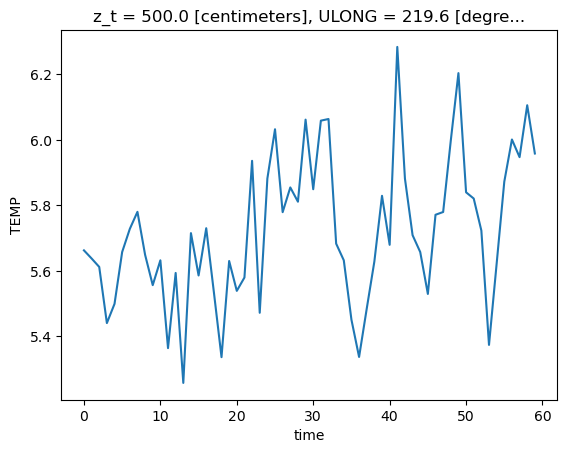

In [72]:
ds.TEMP.isel(z_t=0, nlat=340, nlon=220).plot()

In [36]:
i = 0
for file in file_paths:
    
    if i == 0:
        ds_0 = xr.open_dataset(file)
        
    elif i == 1:
        ds_1 = xr.open_dataset(file)
        
    elif i == 2:
        ds_2 = xr.open_dataset(file)
        
    i = i+1


In [39]:
ds_0

<xarray.Dataset>
Dimensions:                 (time: 60, z_t: 60, nlat: 384, nlon: 320, z_w: 60,
                             z_t_150m: 15, z_w_top: 60, z_w_bot: 60,
                             lat_aux_grid: 395, moc_z: 61)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * time                    (time) datetime64[ns] 1851-01-15T18:00:00 ... 191...
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
    ULONG                   (nlat, nlon) float64 ...
    ULAT                    (nlat, nlon) float64 ...
    TLONG                   (nlat, nlon) float64 ...
    TLAT                    (nlat, nlon) float64 ...
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/51)
    dz                      (time, z_t, nlat, nlon) float32 ...
    dzw                     (time, z_w, nlat, nlon) float32 ...
    KMT                     (time, nlat, nlon) float64 ...
    KMU                     (time, nlat, nlon) float64 ...
    REGION_MASK             (time, nlat, nlon) float64 ...
    UAREA                   (time, nlat, nlon) float64 ...
    ...                      ...
    fwflux_factor           (time, nlat, nlon) float64 ...
    salinity_factor         (time, nlat, nlon) float64 ...
    sflux_factor            (time, nlat, nlon) float64 ...
    nsurface_t              (time, nlat, nlon) float64 ...
    nsurface_u              (time, nlat, nlon) float64 ...
    TEMP                    (time, z_t, nlat, nlon) float32 ...

In [37]:
datasets = [ds_0, ds_1, ds_2]

# Concatenate along a new dimension (e.g., 'ensemble')
combined = xr.concat(datasets, dim='ensemble')

# Compute the mean along the 'ensemble' dimension
average_ds = combined.mean(dim='ensemble')


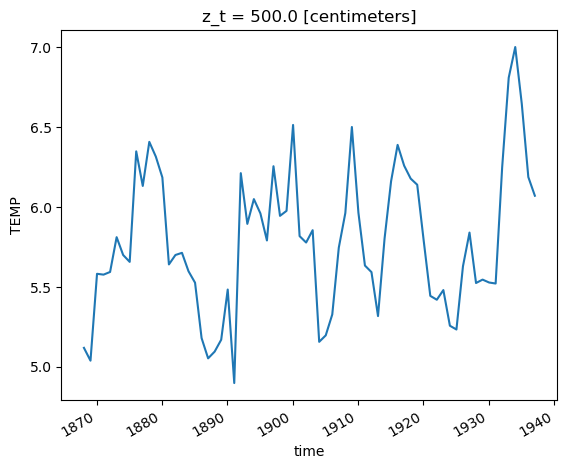

In [38]:
average_ds.TEMP.isel(z_t=0, nlat=340, nlon=220).plot()

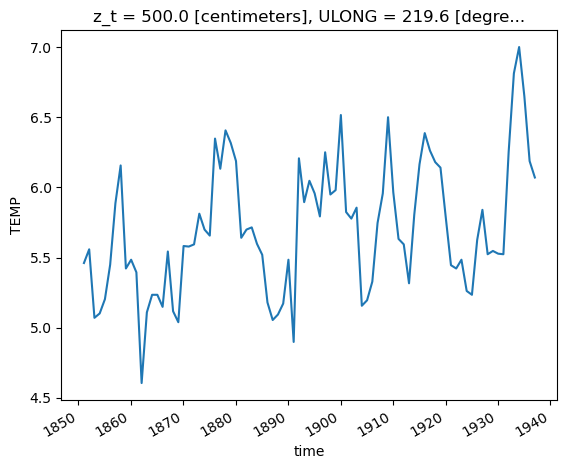

In [74]:
average_ds.TEMP.isel(z_t=0, nlat=340, nlon=220).plot()

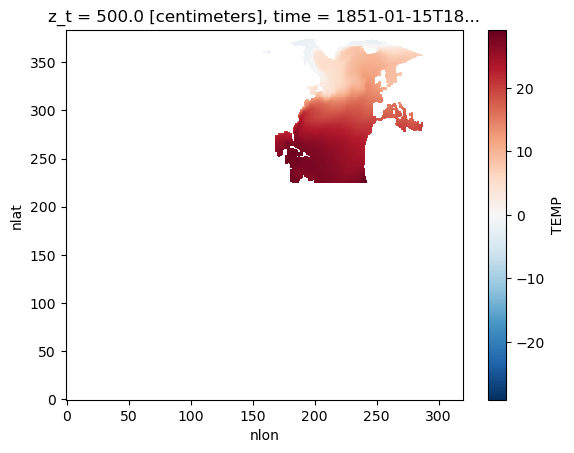

In [75]:
average_ds.TEMP.isel(z_t=0, time=0).plot()

In [58]:
ds = ds_member.isel(time=time_slice)
event_period = []
for t in range(len(ds.time)):
    event_period.append(ds.isel(time=t))
composite_dataset = xr.concat(event_period, dim='time')

In [59]:
composite_dataset.TEMP.isel()

<xarray.Dataset>
Dimensions:                 (time: 60, z_t: 60, nlat: 384, nlon: 320, z_w: 60,
                             z_t_150m: 15, z_w_top: 60, z_w_bot: 60,
                             lat_aux_grid: 395, moc_z: 61)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * time                    (time) datetime64[ns] 1851-01-15T18:00:00 ... 191...
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/51)
    dz                      (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    dzw                     (time, z_w, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    KMT                     (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    KMU                     (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    REGION_MASK             (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    UAREA                   (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ...                      ...
    fwflux_factor           (time, nlat, nlon) float64 nan nan nan ... nan nan
    salinity_factor         (time, nlat, nlon) float64 nan nan nan ... nan nan
    sflux_factor            (time, nlat, nlon) float64 nan nan nan ... nan nan
    nsurface_t              (time, nlat, nlon) float64 nan nan nan ... nan nan
    nsurface_u              (time, nlat, nlon) float64 nan nan nan ... nan nan
    TEMP                    (time, z_t, nlat, nlon) float16 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>

In [ ]:
def process_files(member, group_data, var):
    member_id = f"{float(member):.3f}"
    ds_member = prepare_ds_member(var, member_id)
    print(member, ' started')
    for event, condition in zip(group_data['Values'], group_data['Condition']):
        # select details to one event
        event_time = event
        period_start = event_time - P1_len
        period_end = event_time + P2_len
        time_slice = slice(period_start, period_start)
        # add to list of selected members
        try:
            ds_period = ds_member.isel(time=time_slice)
            if condition == "Above":
                datasets_increase.append(ds_period)
            elif condition == "Below":
                datasets_decrease.append(ds_period)
            ds_period.close()
        except ValueError as e:
            continue
        # if list grows too long, average over list, 
        # and save in temporary storage
        if len(datasets_decrease) >= 3:
            composite_dataset_decrease = compute_composite_timeseries(datasets_decrease)
            composite_dataset_decrease.to_netcdf(temporary_path+file_pattern_decrease+str(count_decrease)+'.nc')
            count_decrease += 1
            composite_dataset_decrease.close()
            datasets_decrease = []
            print('saved decrease chunk: ', count_decrease)
        if len(datasets_increase) >= 3:
            composite_dataset_increase = compute_composite_timeseries(datasets_increase)
            composite_dataset_increase.to_netcdf(temporary_path+file_pattern_increase+str(count_increase)+'.nc')
            count_increase += 1
            composite_dataset_increase.close()
            datasets_increase = []
            print('saved increase chunk: ', count_increase)
    ds_member.close()
    # save final open datasets
    if datasets_decrease:
        composite_dataset_decrease = compute_composite_timeseries(datasets_decrease)
        count_decrease += 1
        composite_dataset_decrease.to_netcdf(temporary_path+file_pattern_decrease+str(count_decrease)+'.nc')
        composite_dataset_decrease.close()
        print('saved last decrease chunk')
    if datasets_increase:
        composite_dataset_increase = compute_composite_timeseries(datasets_increase)
        count_increase += 1
        composite_dataset_increase.to_netcdf(temporary_path+file_pattern_increase+str(count_increase)+'.nc')
        composite_dataset_increase.close()
        print('saved last increase chunk')

In [ ]:
# select member
tasks = []
for member, group_data in grouped:
    # Create a delayed task for each member processing
    task = dask.delayed(process_files)(member, group_data, var)
    tasks.append(task)

# Compute all the delayed tasks in parallel
dask.compute(*tasks)

clear_memory()


if count_decrease > 0:
    final_composites(file_pattern_decrease, decrease_save_name[i])  

if count_increase > 0:
    final_composites(file_pattern_increase, increase_save_name[i])

In [ ]:
always short and concise answers. only print code when explicitly asked. and only print entire codes when explicitly asked. 

In [ ]:
i would like to write a python file that can cue files, give them input, and let me know per email when filesa re compete or errors occur